In [210]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

In [211]:
country='DEU'

carriers = [
    "onwind",
    "offwind",
    "solar",
    "OCGT",
    "CCGT",
    "hydro",
    "ror",
    "coal",
    "lignite",
    "biomass CHP",
    "battery storage",
]

In [212]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

Initialize model

In [213]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

network.add("Bus",
            "electricity")

Index(['electricity'], dtype='object')

Load data

In [214]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)

df_offhorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offhorewind.index = pd.to_datetime(df_offhorewind.index)

df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)

Financial data

In [215]:
costs = pd.read_csv("data/costs_2020.csv", index_col=[0, 1])
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")


defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

costs["marginal_cost"] = costs["VOM"] + (costs["fuel"] / costs["efficiency"])
annuity_results = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity_results + (costs["FOM"] / 100)) * costs["investment"]

costs = costs.loc[costs.index.get_level_values(0).isin(carriers)]
costs[["CO2 intensity", 'efficiency', 'investment', 'lifetime', "FOM", "VOM", "marginal_cost", "capital_cost"]]

parameter,CO2 intensity,efficiency,investment,lifetime,FOM,VOM,marginal_cost,capital_cost
technology,,,,,,,,
CCGT,0.1980,0.5600,931235.0,25.0,3.3295,4.6562,48.527629,110915.226329
OCGT,0.1980,0.4000,480390.3,25.0,1.7772,4.7620,66.182000,49760.036522
battery storage,0.0000,1.0000,245507.4,20.0,0.0000,0.0000,0.000000,23174.161778
biomass CHP,0.0000,0.2994,3578134.9,25.0,3.6081,2.2291,2.229100,436144.291781
coal,0.3361,0.3560,3827162.9,40.0,1.3100,3.2612,30.098840,337208.027448
hydro,0.0000,0.9000,2274817.7,80.0,1.0000,0.0000,0.000000,182698.734592
lignite,0.4069,0.3300,3827162.9,40.0,1.3100,3.2612,13.256655,337208.027448
offwind,0.0000,1.0000,1992610.5,27.0,2.5093,0.0212,0.021200,216235.568851
onwind,0.0000,1.0000,1183911.9,27.0,1.2514,1.5873,1.587300,113584.192786


In [216]:
costs.at["solar", "capital_cost"] = annuity(25,0.07)*425000*(1+0.03) # in €/MW

Capacity Factors

In [217]:
CF_onwind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CF_offwind = df_offhorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

Adding Carriers to the network

In [218]:
network.add(
    "Carrier",
    carriers,
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Index(['onwind', 'offwind', 'solar', 'OCGT', 'CCGT', 'hydro', 'ror', 'coal',
       'lignite', 'biomass CHP', 'battery storage'],
      dtype='object')

Adding Load to the network

<Axes: xlabel='snapshot', ylabel='MW'>

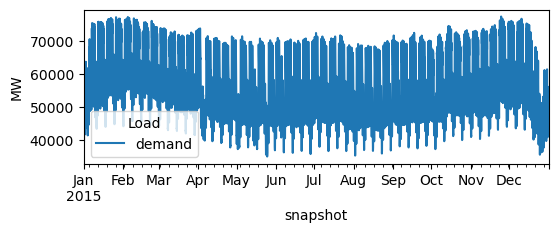

In [219]:
# add load to the bus
network.add("Load",
      "demand",
      bus="electricity",
      p_set=df_elec[country].values)
network.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

Add the generators

In [220]:
## Renewables
# add onshore wind generator
network.add("Generator",
            "onshorewind",
            bus="electricity",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = costs.at["onwind", "capital_cost"],
            marginal_cost = costs.at["onwind", "marginal_cost"],
            p_max_pu = CF_onwind.values)

# add offshore wind generator
network.add("Generator",
            "offshorewind",
            bus="electricity",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = costs.at["offwind", "capital_cost"],
            marginal_cost = costs.at["offwind", "marginal_cost"],
            p_max_pu = CF_offwind.values)

# add solar
network.add("Generator",
            "solar",
            bus="electricity",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = costs.at["solar", "capital_cost"],
            marginal_cost = costs.at["solar", "marginal_cost"],
            p_max_pu = CF_solar.values)

# add biomass
# TODO: research and add capacity/production limit
network.add(
            "Generator",
            "biomass CHP",
            bus="electricity",
            carrier="biomass CHP",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost=costs.at["biomass CHP", "capital_cost"],
            marginal_cost=costs.at["biomass CHP", "marginal_cost"],
            efficiency=costs.at["biomass CHP", "efficiency"],
            p_nom_extendable=True)

# add hydro river
# TODO: research and add capacity/production limit
network.add(
            "Generator",
            "ror",
            bus="electricity",
            carrier="ror",
            p_nom_max=4, # maximum capacity can be limited due to environmental constraints
            capital_cost=costs.at["ror", "capital_cost"],
            marginal_cost=costs.at["ror", "marginal_cost"],
            efficiency=costs.at["ror", "efficiency"],
            p_nom_extendable=True)

# add hydro reservoir
# TODO: research and add capacity/production limit
network.add(
            "Generator",
            "hydro",
            bus="electricity",
            carrier="hydro",
            p_nom_max=4, # maximum capacity can be limited due to environmental constraints
            capital_cost=costs.at["hydro", "capital_cost"],
            marginal_cost=costs.at["hydro", "marginal_cost"],
            efficiency=costs.at["hydro", "efficiency"])

## conventional
# add OCGT (Open Cycle Gas Turbine) generator
network.add("Generator",
            "OCGT",
            bus="electricity",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = costs.at["OCGT", "capital_cost"],
            marginal_cost = costs.at["OCGT", "marginal_cost"])

network.add(
            "Generator",
            "CCGT",
            bus="electricity",
            carrier="CCGT",
            capital_cost=costs.at["CCGT", "capital_cost"],
            marginal_cost=costs.at["CCGT", "marginal_cost"],
            efficiency=costs.at["CCGT", "efficiency"],
            p_nom_extendable=True)

network.add(
            "Generator",
            "coal",
            bus="electricity",
            carrier="coal",
            capital_cost=costs.at["coal", "capital_cost"],
            marginal_cost=costs.at["coal", "marginal_cost"],
            efficiency=costs.at["coal", "efficiency"],
            p_nom_extendable=True)

network.add(
            "Generator",
            "lignite",
            bus="electricity",
            carrier="lignite",
            capital_cost=costs.at["lignite", "capital_cost"],
            marginal_cost=costs.at["lignite", "marginal_cost"],
            efficiency=costs.at["lignite", "efficiency"],
            p_nom_extendable=True)

Index(['lignite'], dtype='object')

In [221]:
network.optimize(solver_name="highs")

Index(['onshorewind', 'offshorewind', 'OCGT'], dtype='object', name='Generator')
Index(['electricity'], dtype='object', name='Bus')


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 22.49it/s]
INFO:linopy.io: Writing time: 0.59s


Running HiGHS 1.9.0 (git hash: n/a): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-03, 1e+00]
  Cost   [1e-02, 5e+07]
  Bound  [0e+00, 0e+00]
  RHS    [4e+00, 8e+04]
Presolving model
83352 rows, 74601 cols, 223776 nonzeros  0s
83352 rows, 74601 cols, 223776 nonzeros  0s
Presolve : Reductions: rows 83352(-100618); columns 74601(-13008); elements 223776(-113626)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(5.12187e+09) 0s
      70649     2.8850773778e+10 Pr: 0(0) 5s
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-gkybwslq
Model status        : Optimal
Simplex   iterations: 70649
Objective value     :  2.8850773778e+10
Relative P-D gap    :  3.2341418582e-13
HiGHS run time      :          4.65
Writing the solution to /private/var/folders/v4/lzkm2zzd3gb0q8rqggx5drch0000gn/T/linopy-solve-5747

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87609 primals, 183970 duals
Objective: 2.89e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [222]:
network.objective / 1e9

28.85077377795162

In [223]:
network.generators.p_nom_opt.div(1e3)  # MW -> GW

Generator
onshorewind     -0.000
offshorewind    -0.000
solar           -0.000
biomass CHP     -0.000
ror              0.004
hydro            0.000
OCGT            15.404
CCGT            12.703
coal            -0.000
lignite         49.385
Name: p_nom_opt, dtype: float64

In [224]:
network.generators_t.p.sum().div(1e6)  # MWh -> TWh

Generator
onshorewind       0.000000
offshorewind      0.000000
solar             0.000000
biomass CHP       0.000000
ror               0.035040
hydro             0.000000
OCGT             22.115195
CCGT             61.040428
coal              0.000000
lignite         422.073900
dtype: float64

<Axes: xlabel='snapshot', ylabel='dispatch'>

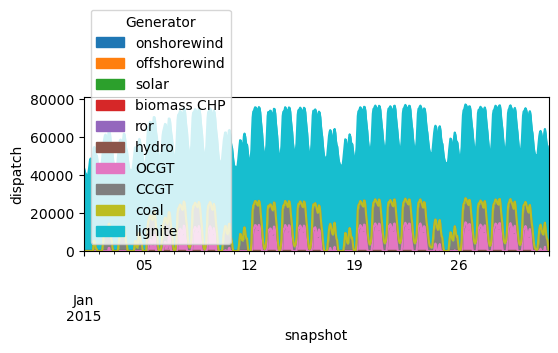

In [225]:
network.generators_t.p.loc["2015-01"].plot.area(figsize=(6, 2), ylabel="dispatch")

In [180]:
dispatch_by_carrier = (
    network.generators_t.p
    .mul(network.snapshot_weightings.generators, axis=0)  # weight by time
    .sum()
    .groupby(network.generators.carrier)
)
print(dispatch_by_carrier)
